In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import string
import numpy as np
import six
import dataframe_image as dfi

import matplotlib.pyplot as plt

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
#definition de la bdd
db = 'data/memoire.db'

In [4]:
#connexion à la bdd, crée la bdd si elle n'existe pas encore
cn=sql.connect(db)

In [5]:
#suppression de table dans la BDD
#cursor = cn.cursor()
#delete_table = """DROP TABLE nom_de_la_table"""
#cursor.execute(delete_table)

## Recherche dans la BDD

### Lister les colonnes de la BDD

In [5]:

conn = sql.connect(db)
c=conn.cursor()

c.execute('SELECT * FROM Silex')
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchall()
names = list(map(lambda x: x[0], c.description))


# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
names

['idx',
 'N°_dépot',
 'N°_caisse',
 'Localité',
 'année',
 'N°_cantonal',
 'Lieu_dit',
 'N°_terrain',
 'Matière',
 'Caractéristique',
 'Description_de_l_objet',
 'Altitude',
 'UF',
 'Période_culturelle',
 'Année_de_restauration',
 'Etat_de_conservation',
 'Fiche_ITMS_non',
 'Remarque_restauration',
 'Coord_X',
 'Coord_Y',
 'Mat_prem',
 'Typologie',
 'Integrite',
 'Etat_surface',
 'Longueur',
 'Largeur',
 'Epaisseur',
 'Poids',
 'Type_de_talon',
 'Bulbe',
 'Levre',
 'Esquille_bulbaire',
 'Retouche',
 'Cortex',
 'Dessin',
 'Remarque',
 'Technologie',
 'Accident']

### Extraction des données

#### Requêtes

In [20]:
#Cette requête cherche les nucléus. Elle va chercher la forme, le nombre de plans de frappe et la finalité de chacun dans 
#les différents tableaux où ces informations sont stockées
#Dans la ligne SELECT, on mentionne les éléments que l'on veut retirés
#FROM Silex s indique que notre information pricipale part de la table silex
#Avec les LEFT JOIN, on y joint les autres tables en se référents aux clès primaires de celles-ci à part de l'information qu'on possède
#La dernière ligne sert à ne retenir que les Nucléus, identifiés car ils sont listés dans la table Nucléus
query_Nucléus ="""
SELECT s.N°_cantonal, s.UF, s.Technologie, r.Delineation_du_bord_retouche
FROM Silex s 
    LEFT JOIN Retouches r ON s.N°_cantonal = r.N°_cantonal
WHERE r.Delineation_du_bord_retouche='COC' AND s.Technologie IS NOT 'Lamelle' AND s.Technologie IS NOT 'Lame' OR r.Delineation_du_bord_retouche='DEN' AND s.Technologie IS NOT 'Lamelle' AND s.Technologie IS NOT 'Lame'
"""

In [57]:
query="""
SELECT N°_cantonal, Longueur, Largeur, Epaisseur FROM Silex
WHERE Technologie='Nucléus' AND UF IS NOT 'L7'
"""

In [68]:
query_Nucléus ="""
SELECT s.N°_cantonal, s.UF, s.Technologie, r.Delineation_du_bord_retouche
FROM Silex s 
    LEFT JOIN Retouches r ON s.N°_cantonal = r.N°_cantonal
WHERE r.Delineation_du_bord_retouche='COH' AND s.Technologie IS NOT 'Lamelle' AND s.Technologie IS NOT 'Lame'
"""

In [238]:
query_esquille="""
SELECT N°_cantonal, Longueur, Largeur, Epaisseur, Mat_prem, Accident, Integrite, Type_de_talon, Bulbe, Levre, Esquille_bulbaire FROM Silex
WHERE Technologie='Esquille'
"""

In [135]:
query_lamelle_dim="""
SELECT N°_cantonal, Longueur, Largeur, Epaisseur FROM Silex
WHERE Technologie='Lamelle' AND Integrite IS NOT 'EN' AND Integrite IS NOT 'LAT'
"""

In [143]:
query_lamelle_talon="""
SELECT s.N°_cantonal, s.Type_de_talon, t.Nom_complet FROM Silex s
    LEFT JOIN Talon t ON s.Type_de_talon=t.Abbreviation
WHERE Technologie='Lamelle' AND Type_de_talon IS NOT 'IN'
"""

In [38]:
query_lame="""
SELECT N°_cantonal, Longueur, Largeur, Epaisseur, Mat_prem, Accident, Integrite, Type_de_talon, Bulbe, Levre, Esquille_bulbaire FROM Silex
WHERE Technologie='Lame'
"""

In [78]:
query_lame_talon="""
SELECT s.N°_cantonal, s.Type_de_talon, t.Nom_complet FROM Silex s
    LEFT JOIN Talon t ON s.Type_de_talon=t.Abbreviation
WHERE Technologie='Lame' AND Type_de_talon IS NOT 'IN'
"""

In [160]:
query_lame_levbul="""
SELECT s.N°_cantonal, l.Nom_complet, b.Nom_complet, e.Nom_complet FROM Silex s
    LEFT JOIN Presence_observation l ON s.Levre=l.Abbreviation
    LEFT JOIN Presence_observation b ON s.Bulbe=b.Abbreviation
    LEFT JOIN Presence_observation e ON s.Esquille_bulbaire=e.Abbreviation
WHERE Technologie='Lame'
"""

In [205]:
query_lamelle_levbul="""
SELECT s.N°_cantonal, l.Nom_complet, b.Nom_complet, e.Nom_complet FROM Silex s
    LEFT JOIN Presence_observation l ON s.Levre=l.Abbreviation
    LEFT JOIN Presence_observation b ON s.Bulbe=b.Abbreviation
    LEFT JOIN Presence_observation e ON s.Esquille_bulbaire=e.Abbreviation
WHERE Technologie='Lamelle'
"""

In [329]:
query_eclat_dim="""
SELECT N°_cantonal, Longueur, Largeur, Epaisseur FROM Silex
WHERE Technologie='Éclat'
"""

In [352]:
query_eclat_talon="""
SELECT s.N°_cantonal, s.Type_de_talon, t.Nom_complet FROM Silex s
    LEFT JOIN Talon t ON s.Type_de_talon=t.Abbreviation
WHERE Technologie='Éclat' AND Type_de_talon IS NOT 'IN'
"""

In [384]:
query_eclat_levbul="""
SELECT s.N°_cantonal, l.Nom_complet, b.Nom_complet, e.Nom_complet FROM Silex s
    LEFT JOIN Presence_observation l ON s.Levre=l.Abbreviation
    LEFT JOIN Presence_observation b ON s.Bulbe=b.Abbreviation
    LEFT JOIN Presence_observation e ON s.Esquille_bulbaire=e.Abbreviation
WHERE Technologie='Éclat'
"""

In [598]:
query_typo="""
SELECT s.N°_cantonal, s.Typologie, s.Technologie FROM Silex s
    LEFT JOIN Retouches r ON s.Retouche=r.N°_cantonal
    LEFT JOIN Localisation_observation l ON r.Localisation_sur_la_piece=l.Abbreviation
    LEFT JOIN Code_retouche c ON r.Delineation_du_bord_retouche=c.Abbreviation
Where s.Retouche IS NOT NULL AND s.Typologie IS NOT NULL
GROUP BY s.N°_cantonal
"""

In [103]:
query="""
SELECT UF, Coord_X, Coord_Y FROM Silex
WHERE Technologie IS NOT "Néolithique" AND 
Technologie IS NOT "Néandertal" AND 
Technologie IS NOT "Débris" AND 
Technologie IS NOT "Debris" AND 
Technologie IS NOT "Naturel"
"""

In [115]:
query_uf="""
SELECT DISTINCT UF, Coord_X, Coord_Y FROM Silex
WHERE Technologie IS NOT "Néolithique" AND 
Technologie IS NOT "Néandertal" AND 
Technologie IS NOT "Débris" AND 
Technologie IS NOT "Debris" AND 
Technologie IS NOT "Naturel"
"""

In [117]:
#Effectuer la requête dans la base de données


# connnexion à la base de données
conn = sql.connect(db)

### Execution de la requête
c = conn.cursor()
c.execute(query_uf)

#extraction des information
rc = c.fetchall()

# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
len(rc)

127

In [97]:
### Executer une requête simple directement dans le code d'execution

# connnexion à la base de données
conn = sql.connect(db)

### exécuter la requête
c = conn.cursor()
#On entre la requête dans execute()
c.execute('SELECT N°_cantonal, Technologie FROM Silex')

#Extraction des données
rc = c.fetchall()

# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
rc[2]

(7835, 'Éclat')

In [7]:
rc[:3]

[(7834, 47.6, 11), (7840, 27.6, 8.8), (7844, 84.5, 25.6)]

In [117]:
#Boucle pour trier les lamelles et les lames sur le critère défini que la largeur d'une lame >=15mm
a=[]
for i in rc:
    g=list(i)
    if i[1]<14.21:
        g[2]='Lamelle'
    else:
        g[2]='Lame'
    h=tuple(g)
    a.append(h)
    
a[2]

(7844, 84.5, 'Lame')

In [128]:
#Faire une boucle pour attribuer ces valeurs aux silex appropriées
# connnexion à la base de données
conn = sql.connect(db)
c = conn.cursor()

#Boucle dans notre liste
for i in a:
    idsilex=str(i[0])
    Typ=str(i[2])
    #print(idsilex,x,y)
    tex=('UPDATE Silex SET Technologie ='+Typ+' WHERE N°_cantonal='+idsilex)
    #tey=("UPDATE base SET Coord_Y ="+y+" WHERE N°_cantonal ="+idsilex)
    c.execute(tex)
    #c.execute(tey)
    #!!!!!!!!mis en commentaire pour éviter que ça réaffecte la base de données!!!!!#     
conn.commit()

conn.close()


OperationalError: no such column: Lame

In [110]:
#Faire une boucle pour attribuer ces valeurs aux silex appropriées
# connnexion à la base de données
conn = sql.connect(db)
c = conn.cursor()

#Boucle dans notre liste
for i in truc:
    idsilex=str(i[0])
    x=str(i[1])
    #y=str(i[2])
    #print(idsilex,x,y)
    tex=("UPDATE Silex SET Coord_X ="+x+" WHERE N°_cantonal ="+idsilex)
    #tey=("UPDATE Silex SET Coord_Y ="+y+" WHERE N°_cantonal ="+idsilex)
    c.execute(tex)
    c.execute(tey)
    #!!!!!!!!mis en commentaire pour éviter que ça réaffecte la base de données!!!!!#     
conn.commit()

conn.close()

In [9]:
tex="N°_cantonal, Longueur, Largeur, Epaisseur, Mat_prem, Accident, Integrite, Type_de_talon, Bulbe, Levre, Esquille_bulbaire"
txt=tex.split(", ")
txt

['N°_cantonal',
 'Longueur',
 'Largeur',
 'Epaisseur',
 'Mat_prem',
 'Accident',
 'Integrite',
 'Type_de_talon',
 'Bulbe',
 'Levre',
 'Esquille_bulbaire']

## Créer un tableau et montre les données

In [241]:
df_silex = pd.DataFrame(rc, columns=['N°_cantonal',
 'Longueur',
 'Largeur',
 'Epaisseur',
 'Mat_prem',
 'Accident',
 'Integrite',
 'Type_de_talon',
 'Bulbe',
 'Levre',
 'Esquille_bulbaire'])
df_silex.head()

,N°_cantonal,Longueur,Largeur,Epaisseur,Mat_prem,Accident,Integrite,Type_de_talon,Bulbe,Levre,Esquille_bulbaire
0,7854,5.1,4.2,1.1,1.0,None,IN,IN,IN,IN,IN
1,7860,9.7,5.1,2.1,1.0,None,IN,IN,IN,IN,IN
2,7899,9.9,6.2,2.5,1.0,None,IN,IN,IN,IN,IN
3,7906,7.4,4.6,1.3,1.0,None,PX,LI,PR,AB,AB
4,7916,9.0,7.1,2.4,7846.0,None,IN,IN,IN,IN,IN


In [118]:
df_silex = pd.DataFrame(rc, columns=['UF', "Coord_X", "Coord_Y"])
df_silex.head()

,UF,Coord_X,Coord_Y
0,A5,0.0,5.0
1,A6,0.0,6.0
2,A7,0.0,7.0
3,A8,0.0,8.0
4,A9,0.0,9.0


In [451]:
df_silex = pd.DataFrame(rc, columns=['N°_cantonal','Typologie','Localisation','delineation'])
df_silex

,N°_cantonal,Typologie,Localisation,delineation
0,7844,None,Distale,Concave
1,7844,None,Mésiale,Irrégulière
2,7844,None,Proximale,Concave
3,7844,None,Proximale,Irrégulière
4,7856,None,Distale,Concave
...,...,...,...,...
126,10453,None,Proximale,Régulière
127,1825,None,Bout,Convexe
128,1839,None,Mésiale,Concave
129,1846,None,Bout,Régulière


In [61]:
#Calcul du volume des pièces
a=[]
for i in df_silex.index:
    a.append(((df_silex['Longueur'][i]) * (df_silex['Largeur'][i]) * (df_silex['Epaisseur'][i]))/1000)
a[3]

23.472175999999997

In [62]:
#Insertion d'une colonne volume à la dataframe
df_silex.insert(4, 'Volume', a, True)

In [348]:
#Ajout d'une ligne pour la moyenne
df_silex.loc['mean']=df_silex.mean(numeric_only=True)

In [453]:
df_silex.sort_values(by='Typologie')

,N°_cantonal,Typologie,Localisation,delineation
0,7844,None,Distale,Concave
1,7844,None,Mésiale,Irrégulière
2,7844,None,Proximale,Concave
3,7844,None,Proximale,Irrégulière
4,7856,None,Distale,Concave
...,...,...,...,...
126,10453,None,Proximale,Régulière
127,1825,None,Bout,Convexe
128,1839,None,Mésiale,Concave
129,1846,None,Bout,Régulière


In [349]:
df_silex

,N°_cantonal,Longueur,Largeur,Epaisseur
0,7835.000000,27.700000,21.800000,15.000000
1,7854.000000,5.100000,4.200000,1.100000
2,7855.000000,48.800000,29.200000,22.600000
3,7859.000000,13.900000,11.300000,2.700000
4,7860.000000,9.700000,5.100000,2.100000
...,...,...,...,...
479,1909.000000,22.400000,8.900000,3.000000
480,1911.000000,26.700000,17.000000,7.700000
481,1914.000000,41.500000,38.300000,11.300000
482,2236.000000,18.100000,20.000000,15.300000


In [29]:
df_silex['Volume']=df_silex['Volume']/1000

In [65]:
df_silex.rename(columns = {'Volume':'Volume (cm3)'}, inplace = True)
df_silex.rename(columns = {'Longueur':'Longueur (mm)'}, inplace = True)
df_silex.rename(columns = {'Largeur':'Largeur (mm)'}, inplace = True)
df_silex.rename(columns = {'Epaisseur':'Epaisseur (mm)'}, inplace = True)


In [67]:
df_silex.to_excel('Dimension_nucleus.xlsx')

In [30]:
#cette ligne sert à remplacé les emplacement "NULL" ou "None" dans la dataframe (colonne 'finalité') par 'indeterminable.
#De cette façon, ces entrées pourrons être prises en compte dans l'élaboration de figure ou de statistiques.
df_silex.Plan_de_frappe.fillna('indeterminable', inplace=True)

In [360]:
df_Techno = pd.DataFrame(rc, columns=['N°_cantonal','Abbrev','Type_de_talon'])
df_Techno.head()

,N°_cantonal,Abbrev,Type_de_talon
0,7880,LI,Lisse
1,7906,LI,Lisse
2,7910,LI,Lisse
3,7922,LI,Lisse
4,8055,LI,Lisse


In [361]:
df_Techno.drop(columns='Abbrev')

,N°_cantonal,Type_de_talon
0,7880,Lisse
1,7906,Lisse
2,7910,Lisse
3,7922,Lisse
4,8055,Lisse
...,...,...
194,1904,Lisse
195,1906,Lisse
196,1909,Lisse
197,1914,Lisse


In [90]:
df_silex_propre = pd.DataFrame(rc, columns=['N°_Cantonal','Longueur (mm)','Largeur (mm)'])
df_silex_propre.head()

,N°_Cantonal,Longueur,Largeur
0,7834,47.6,11.0
1,7840,27.6,8.8
2,7844,84.5,25.6
3,7846,36.4,16.6
4,7851,14.2,12.2


In [109]:
lst = list(range(1,25+1))

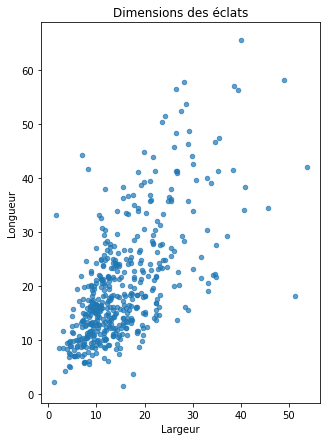

In [333]:
df_plot=df_silex.plot.scatter(title="Dimensions des éclats", x="Largeur", y="Longueur", alpha=0.7, figsize=(5,7))

In [334]:
ListeLargeur=df_silex["Longueur"].to_list()

In [335]:
# Compter les largeurs par mm
counterListeAnnees = Counter(ListeLargeur)
groupedListeLargeur = list(zip(counterListeAnnees.keys(), counterListeAnnees.values()))

In [336]:
#définir la plage de largeur souhaitée
p=1

In [337]:
### Créer la liste des Largeur de 1mm, je commence à 5
d1List = []
period = p
d_start = 5
i = 0
d1List.append(d_start)

while i < 55:
    d_start = d_start + period
    d1List.append(d_start)
    i += 1

In [338]:
# Regroupement par Largeur de 1mm
i1List = []
for i in d1List:
    i_n = 0
    for l in groupedListeLargeur:
        if l[0] >= i and l[0] < (i + p):
            i_n = i_n + l[1]
    i1List.append([i, i_n])     

In [339]:
#limite l'axe des X à deux décimales
for i in i1List:
    i[0]= f'{i[0]:.0f}'

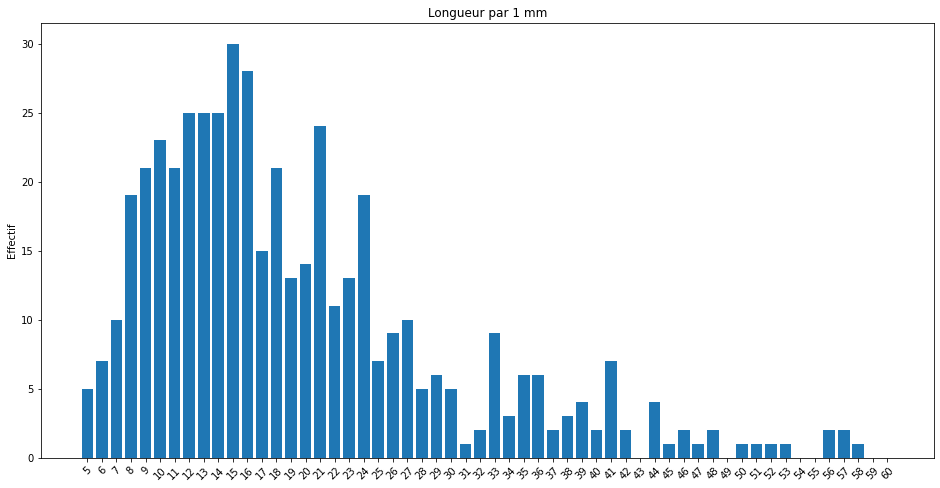

In [340]:
# Distribution par largeur de 1mm
#Montre le diagramme en barres

objects = [str(l[0]) for l in i1List]
eff = [l[1] for l in i1List]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Longueur par 1 mm')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

#montre la boite à moustache
#pt = df_annees.boxplot(column=['annee'], vert=False, figsize=(16,4))
### https://www.pythonprogramming.in/boxplot-adjust-bottom-and-left.html
#ax = fig.add_subplot()
#plt.subplots_adjust(left=0.35)

plt.show()

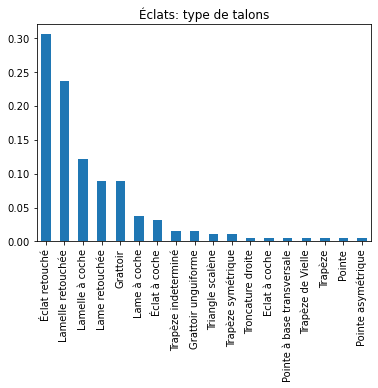

In [540]:
df_plot=df_silex["Typologie"].value_counts(normalize=True).plot(kind='bar', title='Éclats: type de talons')

In [601]:
df_silex.Typologie=df_silex.Typologie.astype(str)

In [602]:
grou=[]
for i in df_silex["Typologie"]:
    if i.__contains__("retouch"):
        grou.append("Objet retouché")
    elif i.__contains__("coch"):
        grou.append("Objet à coche")
    elif i.__contains__("Gratto"):
        grou.append("Grattoir")
    else:
        grou.append("Armature")
        print(i)

Triangle scalène
Pointe
Pointe à base transversale
Trapèze symétrique
Trapèze
Trapèze de Vielle
Trapèze indeterminé
Triangle scalène
Trapèze indeterminé
Troncature droite
Trapèze indeterminé
Trapèze symétrique
Pointe asymétrique


In [603]:
len(grou)

190

In [604]:
df_silex["Groupe"]=grou
df_silex.head()

,N°_cantonal,Typologie,Technologie,Groupe
0,1818,Lamelle retouchée,Lamelle,Objet retouché
1,1825,Grattoir,Éclat,Grattoir
2,1826,Lamelle retouchée,Lamelle,Objet retouché
3,1839,Éclat retouché,Éclat,Objet retouché
4,1841,Triangle scalène,Éclat,Armature


In [613]:
df_pourcent=df_silex.groupby(['Groupe', 'Typologie'], as_index=True, sort=True).size()
#reorderlist=["Grattoir","Grattoir unguiforme","Lame retouchée","Lamelle retouchée","Éclat retouché","Lame à coche","Lamelle à coche","Éclat à coche","Pointe","Pointe asymétrique","Pointe à base transversale","Trapèze","Trapèze de Vielle","Trapèze indeterminé","Trapèze symétrique","Triangle scalène","Troncature droite"]
df_pourcent
#.reindex(["Grattoir","Objet retouché","Objet à coche","Armature"])

Groupe          Typologie                 
Armature        Pointe                         1
                Pointe asymétrique             1
                Pointe à base transversale     1
                Trapèze                        1
                Trapèze de Vielle              1
                Trapèze indeterminé            3
                Trapèze symétrique             2
                Triangle scalène               2
                Troncature droite              1
Grattoir        Grattoir                      17
                Grattoir unguiforme            3
Objet retouché  Lame retouchée                17
                Lamelle retouchée             45
                Éclat retouché                58
Objet à coche   Lame à coche                   7
                Lamelle à coche               23
                Éclat à coche                  7
dtype: int64

In [520]:
type(df_pourcent)

Typologie
Lamelle retouchée             45
Grattoir                      17
Éclat retouché                58
Triangle scalène               2
Lame retouchée                17
Lamelle à coche               23
Pointe                         1
Éclat à coche                  6
Lame à coche                   7
Pointe à base transversale     1
Trapèze symétrique             2
Trapèze                        1
Trapèze de Vielle              1
Trapèze indeterminé            3
Eclat à coche                  1
Grattoir unguiforme            3
Troncature droite              1
Pointe asymétrique             1
dtype: int64

In [416]:
100*df_pourcent/189

Lèvre
Absent          74.074074
Douteux          1.058201
Indeterminé    152.910053
Présent         22.222222
dtype: float64

In [101]:
df_Techno['Compte']=df_Techno['Technologie']

In [632]:
df_group=df_silex.groupby(['Groupe','Typologie'], as_index=False).agg({"Typologie":["size","sum"]})
df_group

Groupe Typologie  \
                        size   
0         Armature         1   
1         Armature         1   
2         Armature         1   
3         Armature         1   
4         Armature         1   
5         Armature         3   
6         Armature         2   
7         Armature         2   
8         Armature         1   
9         Grattoir        17   
10        Grattoir         3   
11  Objet retouché        17   
12  Objet retouché        45   
13  Objet retouché        58   
14   Objet à coche         7   
15   Objet à coche        23   
16   Objet à coche         7   

                                                       
                                                  sum  
0                                              Pointe  
1                                  Pointe asymétrique  
2                          Pointe à base transversale  
3                                             Trapèze  
4                                   Trapèze de Vielle  
5   Trapèze indeterminéTrapèze indeterminéTrapèze ...  
6                Trapèze symétriqueTrapèze symétrique  
7                    Triangle scalèneTriangle scalène  
8                                   Troncature droite  
9   GrattoirGrattoirGrattoirGrattoirGrattoirGratto...  
10  Grattoir unguiformeGrattoir unguiformeGrattoir...  
11  Lame retouchéeLame retouchéeLame retouchéeLame...  
12  Lamelle retouchéeLamelle retouchéeLamelle reto...  
13  Éclat retouchéÉclat retouchéÉclat retouchéÉcla...  
14  Lame à cocheLame à cocheLame à cocheLame à coc...  
15  Lamelle à cocheLamelle à cocheLamelle à cocheL...  
16  Éclat à cocheÉclat à cocheÉclat à cocheÉclat à...

In [640]:
df_group["Somme"]=df_group.groupby(['Groupe'])['nombre'].cumsum()
df_group

,Groupe,Typologie,nombre,%,Somme
0,Armature,Pointe,1,0.526316,1
1,Armature,Pointe asymétrique,1,0.526316,2
2,Armature,Pointe à base transversale,1,0.526316,3
3,Armature,Trapèze,1,0.526316,4
4,Armature,Trapèze de Vielle,1,0.526316,5
5,Armature,Trapèze indeterminé,3,1.578947,8
6,Armature,Trapèze symétrique,2,1.052632,10
7,Armature,Triangle scalène,2,1.052632,12
8,Armature,Troncature droite,1,0.526316,13
9,Grattoir,Grattoir,17,8.947368,17


In [614]:
df_group=df_silex.groupby(['Groupe','Typologie'], as_index=False).size()
df_group['nombre']=df_group['size']
df_group['%']=df_group['size']
df_group['%']=100*df_group['%']/df_group['size'].sum()
del df_group['size']

In [646]:
from pandas.api.types import CategoricalDtype
cat_size_order = CategoricalDtype(
    ["Grattoir","Objet retouché","Objet à coche","Armature"], 
    ordered=True
)

In [649]:
df_total["Groupe"]=df_total["Groupe"].astype(cat_size_order)
df_total.sort_values('Groupe')

,Groupe,Typologie,nombre,%,Somme
10,Grattoir,Grattoir unguiforme,3,1.578947,20.0
9,Grattoir,Grattoir,17,8.947368,17.0
13,Objet retouché,Éclat retouché,58,30.526316,120.0
12,Objet retouché,Lamelle retouchée,45,23.684211,62.0
11,Objet retouché,Lame retouchée,17,8.947368,17.0
16,Objet à coche,Éclat à coche,7,3.684211,37.0
14,Objet à coche,Lame à coche,7,3.684211,7.0
15,Objet à coche,Lamelle à coche,23,12.105263,30.0
0,Armature,Pointe,1,0.526316,1.0
6,Armature,Trapèze symétrique,2,1.052632,10.0


In [200]:
df_group.rename(columns = {'Esquille bulb.':'Esquille_bulbaire'}, inplace = True)

In [559]:
df_group.round(2)

,Typologie,nombre,%
0,NaN,1,0.53
1,Grattoir,17,8.95
2,Grattoir unguiforme,3,1.58
3,Lame retouchée,17,8.95
4,Lame à coche,7,3.68
5,Lamelle retouchée,45,23.68
6,Lamelle à coche,23,12.11
7,Pointe,1,0.53
8,Pointe asymétrique,1,0.53
9,Pointe à base transversale,1,0.53


In [641]:
df_total=df_group.append(df_group.sum(numeric_only=True).rename('Total'))
df_total

,Groupe,Typologie,nombre,%,Somme
0,Armature,Pointe,1.0,0.526316,1.0
1,Armature,Pointe asymétrique,1.0,0.526316,2.0
2,Armature,Pointe à base transversale,1.0,0.526316,3.0
3,Armature,Trapèze,1.0,0.526316,4.0
4,Armature,Trapèze de Vielle,1.0,0.526316,5.0
5,Armature,Trapèze indeterminé,3.0,1.578947,8.0
6,Armature,Trapèze symétrique,2.0,1.052632,10.0
7,Armature,Triangle scalène,2.0,1.052632,12.0
8,Armature,Troncature droite,1.0,0.526316,13.0
9,Grattoir,Grattoir,17.0,8.947368,17.0


In [501]:
#filtrer selon une valeur dans une colonne et créer une df_filtre qui contient uniquement les objets correspondant à la valeur
#df_mask=df_silex['delineation']=='Concave'
df_filtre = df_silex
#[df_mask]
df_filtre.head()

,N°_cantonal,Typologie,Localisation,delineation
6,7918,None,Distale,Régulière
8,7922,None,Distale,Denticulée
11,7933,None,Totale,Régulière
12,7974,None,Proximale,Régulière
18,8072,None,Mésiale,Régulière


In [497]:
#filtrer selon une valeur dans une colonne et créer une df_filtre qui contient uniquement les objets correspondant à la valeur
#df_mask=df_silex['N°_cantonal']=='Bout'
#df_filtre = df_silex[df_mask]
#df_filtre.head()
filtered_df = df_silex[df_silex['N°_cantonal'].isin(b)]
filtered_df

,N°_cantonal,Typologie,Localisation,delineation
0,7844,None,Distale,Concave
1,7844,None,Mésiale,Irrégulière
2,7844,None,Proximale,Concave
3,7844,None,Proximale,Irrégulière
4,7856,None,Distale,Concave
5,7856,None,Proximale,Concave
7,7919,None,Distale,Concave
16,8057,None,Distale,Rectiligne
17,8057,None,Proximale,Concave
31,8190,None,Totale,Concave


In [484]:
df_filtre

,N°_cantonal,Typologie,Localisation,delineation
9,7931,None,Distale,Coche
14,8038,None,Proximale,Coche
21,8095,None,Distale,Coche
22,8095,None,Proximale,Coche
28,8176,None,Mésiale,Coche
47,8402,None,Distale,Coche
71,1852,None,Mésiale,Coche


In [498]:
inde=filtered_df.index

In [471]:
inde

Int64Index([40, 45, 53, 54, 56, 58, 94, 105, 121, 124, 127, 129], dtype='int64')

In [502]:
a=df_filtre.values.tolist()
a

[[7918, None, 'Distale', 'Régulière'],
 [7922, None, 'Distale', 'Denticulée'],
 [7933, None, 'Totale', 'Régulière'],
 [7974, None, 'Proximale', 'Régulière'],
 [8072, None, 'Mésiale', 'Régulière'],
 [8072, None, 'Totale', 'Denticulée'],
 [8077, None, 'Mésiale', 'Denticulée'],
 [8120, None, None, None],
 [8138, None, 'Totale', 'Régulière'],
 [8164, None, 'Mésiale', 'Régulière'],
 [8164, None, 'Totale', 'Régulière'],
 [8168, None, 'Distale', 'Régulière'],
 [8189, None, 'Distale', 'Régulière'],
 [8195, None, 'Distale', 'Convexe'],
 [8197, None, 'Totale', 'Denticulée'],
 [8254, None, 'Totale', 'Régulière'],
 [8276, None, 'Distale', 'Rectiligne'],
 [8287, None, 'Distale', 'Convexe'],
 [8379, None, 'Proximale', 'Régulière'],
 [8385, None, 'Totale', 'Régulière'],
 [8389, None, 'Distale', 'Régulière'],
 [8389, None, 'Totale', 'Régulière'],
 [8440, None, 'Mésiale', 'Régulière'],
 [10361, None, 'Mésiale', 'Régulière'],
 [10361, None, 'Mésiale', 'Régulière'],
 [10361, None, 'Proximale', 'Régulière

In [503]:
b=df_filtre['N°_cantonal'].tolist()
b

[7918,
 7922,
 7933,
 7974,
 8072,
 8072,
 8077,
 8120,
 8138,
 8164,
 8164,
 8168,
 8189,
 8195,
 8197,
 8254,
 8276,
 8287,
 8379,
 8385,
 8389,
 8389,
 8440,
 10361,
 10361,
 10361,
 10644,
 1844,
 1869,
 7874,
 7874,
 7882,
 7883,
 7908,
 7908,
 7942,
 7955,
 7981,
 7982,
 8029,
 8033,
 8076,
 8081,
 8102,
 8108,
 8153,
 8203,
 8257,
 8344,
 8376,
 8391,
 8409,
 8415,
 8424,
 8436,
 8454,
 10453,
 1866]

In [499]:
df_silex.drop(inde,0, inplace=True)
df_silex

C:\Users\arman\miniconda3\envs\memoire\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,N°_cantonal,Typologie,Localisation,delineation
6,7918,None,Distale,Régulière
8,7922,None,Distale,Denticulée
11,7933,None,Totale,Régulière
12,7974,None,Proximale,Régulière
18,8072,None,Mésiale,Régulière
19,8072,None,Totale,Denticulée
20,8077,None,Mésiale,Denticulée
23,8120,None,None,None
24,8138,None,Totale,Régulière
25,8164,None,Mésiale,Régulière


In [504]:
conn = sql.connect(db)
c = conn.cursor()

for i in a:
    idsilex=str(i[0])
    tex=('UPDATE Silex SET Typologie ="Éclat retouché" WHERE N°_cantonal='+idsilex)
    #tey=("UPDATE base SET Coord_Y ="+y+" WHERE N°_cantonal ="+idsilex)
    c.execute(tex)
    #c.execute(tey)
    #!!!!!!!!mis en commentaire pour éviter que ça réaffecte la base de données!!!!!#     
conn.commit()

conn.close()

In [254]:
df_total=df_filtre.append(df_group.mean(numeric_only=True).rename('Moyenne'))
df_total.head()

,N°_cantonal,Longueur,Largeur,Epaisseur,Mat_prem,Accident,Integrite,Type_de_talon,Bulbe,Levre,Esquille_bulbaire,%,nombre
12,8055.0,8.4,9.7,1.3,1.0,None,EN,LI,PR,AB,AB,NaN,NaN
18,8128.0,14.6,11.9,1.4,1.0,None,EN,LI,PR,AB,PR,NaN,NaN
27,8346.0,12.5,4.9,1.6,1.0,None,EN,IN,AB,AB,AB,NaN,NaN
28,8410.0,8.6,6.0,1.2,1.0,None,EN,PU,PR,AB,AB,NaN,NaN
34,8507.0,6.7,4.2,0.7,1.0,None,EN,IN,DI,IN,IN,NaN,NaN


In [255]:
df_total

,N°_cantonal,Longueur,Largeur,Epaisseur,Mat_prem,Accident,Integrite,Type_de_talon,Bulbe,Levre,Esquille_bulbaire,%,nombre
12,8055.0,8.4,9.7,1.3,1.0,None,EN,LI,PR,AB,AB,NaN,NaN
18,8128.0,14.6,11.9,1.4,1.0,None,EN,LI,PR,AB,PR,NaN,NaN
27,8346.0,12.5,4.9,1.6,1.0,None,EN,IN,AB,AB,AB,NaN,NaN
28,8410.0,8.6,6.0,1.2,1.0,None,EN,PU,PR,AB,AB,NaN,NaN
34,8507.0,6.7,4.2,0.7,1.0,None,EN,IN,DI,IN,IN,NaN,NaN
50,8054.0,7.6,10.0,2.1,1.0,None,EN,IN,PR,IN,IN,NaN,NaN
55,8205.0,7.0,5.3,1.3,1.0,None,EN,PU,PR,AB,AB,NaN,NaN
59,8314.0,10.9,9.5,1.8,1.0,None,EN,LI,PR,AB,PR,NaN,NaN
61,8437.0,7.3,14.7,2.6,1.0,None,EN,IN,DI,IN,IN,NaN,NaN
62,8521.0,11.6,8.6,1.7,1.0,None,EN,LI,PR,AB,AB,NaN,NaN


In [643]:
df_total.Typologie.fillna(value='Total', inplace=True)
df_total

,Groupe,Typologie,nombre,%,Somme
0,Armature,Pointe,1.0,0.526316,1.0
1,Armature,Pointe asymétrique,1.0,0.526316,2.0
2,Armature,Pointe à base transversale,1.0,0.526316,3.0
3,Armature,Trapèze,1.0,0.526316,4.0
4,Armature,Trapèze de Vielle,1.0,0.526316,5.0
5,Armature,Trapèze indeterminé,3.0,1.578947,8.0
6,Armature,Trapèze symétrique,2.0,1.052632,10.0
7,Armature,Triangle scalène,2.0,1.052632,12.0
8,Armature,Troncature droite,1.0,0.526316,13.0
9,Grattoir,Grattoir,17.0,8.947368,17.0


In [652]:
df_total.nombre=df_total.nombre.astype(int)
df_total.Somme=df_total.Somme.astype(int)

In [74]:
dfi.export(df_total, 'Talon.png')

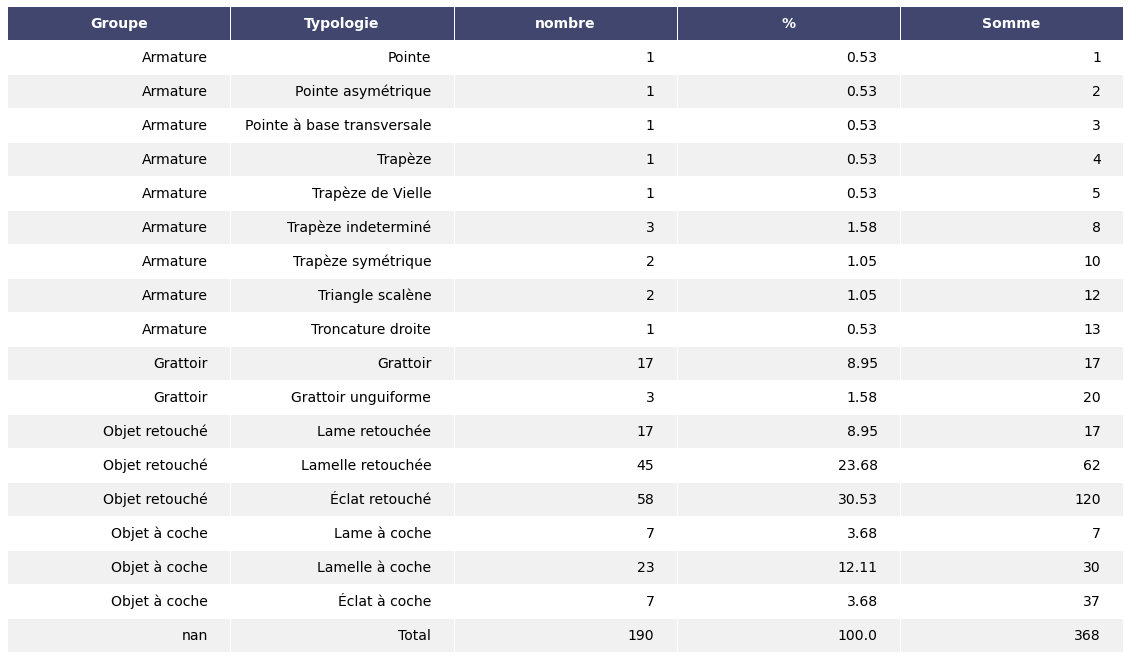

In [653]:
def render_mpl_table(data, col_width=4.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
tableau=render_mpl_table(df_total.round(2), header_columns=0, col_width=4.0)

In [654]:
tableau.get_figure().savefig('Objets_retouches.jpeg')

In [165]:
export_png(tableau, filename = tableau.png)

NameError: name 'export_png' is not defined

In [414]:
df_total

,Esquille_bulbaire,nombre,%
0,Absent,126,26.638478
1,Indeterminé,273,57.716702
2,Présent,74,15.644820
Total,Total,473,100.000000


In [55]:
df_silex.replace("Grattoir unguiforme", "Grattoir", inplace=True)
df_silex[:10]

,N°_cantonal,UF,Typologie,Nombre
0,7834,A5,Lame/Lamelle à coche,Lame/Lamelle à coche
1,7844,A7,Lame/Lamelle retouchée,Lame/Lamelle retouchée
2,7856,A8,Lame/Lamelle retouchée,Lame/Lamelle retouchée
3,7863,A9,Lame/Lamelle retouchée,Lame/Lamelle retouchée
4,7870,A11,Lame/Lamelle retouchée,Lame/Lamelle retouchée
5,7876,B2,Armature,Armature
6,7892,B4,Lame/Lamelle à coche,Lame/Lamelle à coche
7,7896,B4,Lame/Lamelle à coche,Lame/Lamelle à coche
8,7909,B6,Lame/Lamelle retouchée,Lame/Lamelle retouchée
9,7910,B6,Armature,Armature


In [90]:
df_silex['Nombre']=df_silex['Technologie']
df_silex[:10]

,N°_cantonal,UF,Technologie,Coord_X,Coord_Y,Nombre
0,7827,A5,Nucléus,0.0,5.0,Nucléus
1,7834,A5,Lamelle,0.0,5.0,Lamelle
2,7835,A5,Éclat,0.0,5.0,Éclat
3,7840,A6,Lamelle,0.0,6.0,Lamelle
4,7844,A7,Lame,0.0,7.0,Lame
5,7846,A7,Lame,0.0,7.0,Lame
6,7850,A7,Nucléus,0.0,7.0,Nucléus
7,7851,A7,Lamelle,0.0,7.0,Lamelle
8,7854,A7,Éclat,0.0,7.0,Éclat
9,7855,A8,Éclat,0.0,8.0,Éclat


In [91]:
df_silex['Nom']=df_silex['Technologie']

In [93]:
### Regrouper par UF
place_count = df_silex.groupby(['UF', 'Nom', 'Nombre', "Coord_X", "Coord_Y"], as_index=False) \
      .agg({'Technologie': ','.join, 'Nombre': 'count'}).sort_values(by=['UF'])
print(len(place_count))
place_count[:10]

262


,UF,Nom,Coord_X,Coord_Y,Technologie,Nombre
0,A-B5,Lamelle,0.0,5.0,"Lamelle,Lamelle",2
1,A-B5,Éclat,0.0,5.0,"Éclat,Éclat,Éclat,Éclat,Éclat,Éclat,Éclat",7
2,A10,Lamelle,0.0,10.0,Lamelle,1
3,A10,Nucléus,0.0,10.0,Nucléus,1
4,A10,Éclat,0.0,10.0,"Éclat,Éclat,Éclat,Éclat,Éclat",5
5,A11,Lamelle,0.0,11.0,"Lamelle,Lamelle,Lamelle,Lamelle,Lamelle,Lamelle",6
6,A11,Éclat,0.0,11.0,"Éclat,Éclat,Éclat,Éclat,Éclat,Éclat,Éclat,Écla...",18
7,A3,Éclat,0.0,3.0,"Éclat,Éclat,Éclat,Éclat,Éclat",5
8,A4,Éclat,0.0,4.0,"Éclat,Éclat,Éclat",3
9,A5,Lamelle,0.0,5.0,"Lamelle,Lamelle,Lamelle",3


In [94]:
df_carre=place_count.pivot(index='UF', columns='Nom', values='Nombre')
df_carre[:10]

ValueError: Index contains duplicate entries, cannot reshape

In [119]:
df_silex[:10]

,UF,Coord_X,Coord_Y
0,A5,0.0,5.0
1,A6,0.0,6.0
2,A7,0.0,7.0
3,A8,0.0,8.0
4,A9,0.0,9.0
5,A11,0.0,11.0
6,B2,1.0,2.0
7,B4,1.0,4.0
8,A-B5,0.0,5.0
9,B6,1.0,6.0


In [114]:
df=df_silex.groupby(["UF"], as_index=True)
df

In [85]:
df_carre.fillna(0, inplace=True)
df_carre[:10]

Nom,Bloc testé,Lame,Lamelle,Nucléus,Éclat
UF,,,,,
,0.0,0.0,9.0,3.0,7.0
A-B5,0.0,0.0,2.0,0.0,7.0
A10,0.0,0.0,1.0,1.0,5.0
A11,0.0,0.0,6.0,0.0,18.0
A3,0.0,0.0,0.0,0.0,5.0
A4,0.0,0.0,0.0,0.0,3.0
A5,0.0,0.0,3.0,1.0,3.0
A6,0.0,0.0,1.0,0.0,7.0
A7,0.0,2.0,2.0,1.0,6.0


In [120]:
df=df_carre.join(df_silex.set_index("UF"))
df[:10]

,Bloc testé,Lame,Lamelle,Nucléus,Éclat,Coord_X,Coord_Y
UF,,,,,,,
,0.0,0.0,9.0,3.0,7.0,NaN,NaN
A-B5,0.0,0.0,2.0,0.0,7.0,0.0,5.0
A10,0.0,0.0,1.0,1.0,5.0,0.0,10.0
A11,0.0,0.0,6.0,0.0,18.0,0.0,11.0
A3,0.0,0.0,0.0,0.0,5.0,0.0,3.0
A4,0.0,0.0,0.0,0.0,3.0,0.0,4.0
A5,0.0,0.0,3.0,1.0,3.0,0.0,5.0
A6,0.0,0.0,1.0,0.0,7.0,0.0,6.0
A7,0.0,2.0,2.0,1.0,6.0,0.0,7.0


In [108]:
df_carre

Nom,Bloc testé,Lame,Lamelle,Nucléus,Éclat
UF,,,,,
,0.0,0.0,9.0,3.0,7.0
A-B5,0.0,0.0,2.0,0.0,7.0
A10,0.0,0.0,1.0,1.0,5.0
A11,0.0,0.0,6.0,0.0,18.0
A3,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...
Z6,0.0,1.0,0.0,0.0,2.0
Z7,1.0,0.0,1.0,0.0,2.0
Z8,0.0,0.0,3.0,0.0,11.0


In [121]:
df.to_excel(r'Technologie_par_carre_uf.xlsx', index = True)

In [224]:
g=list()
for i in range(len(rc)):
    if "poi" in rc[i][0]:
        g.append(rc[i])
    
len(g)

18

In [225]:
g

[('pointe retouchée à tronquature', 7910),
 ('pointe retouchée', 7934),
 ('pointe à tronquature', 7959),
 ('pointe à retouches denticulées sur 1 côté', 8105),
 ('pointe à tronquature cassée', 8171),
 ('pointe retouchée ?', 8179),
 ('pointe de flèche à ailette, bord denticulé', 8196),
 ('pointe corticale à tronquature', 8211),
 ('pointe  ', 8227),
 ('pointe à tronquature oblique', 8279),
 ('pointe à tronquature ou trapèze?', 8317),
 ('pointe à tronquature oblique', 8355),
 ('pointe à tronquature oblique', 8369),
 ('pointe corticale ?', 8428),
 ('pointe ', 8500),
 ('1 pointe de flèche néol.', 8511),
 ('pointe ', 10465),
 ('pointe', 1869)]

In [226]:
b=list()
for i in range(len(g)):
    a=list(g[i])
    a[0]='Armature'
    b.append(a)
b[4:8]

[['Armature', 8171],
 ['Armature', 8179],
 ['Armature', 8196],
 ['Armature', 8211]]

In [5]:
cn = sql.connect(db)
c = cn.cursor()

# Insérer les données
c.execute("ALTER TABLE Silex ADD COLUMN Accident TEXT REFERENCES Accident(Abbrev)")

# valider l'insertion et fermer la base de données
cn.commit()
cn.close()